In [15]:
import odl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Set hyperparameters
batch_size = 128
learning_rate = 0.005
num_epochs = 5
data_root = './data'

# Radon Transform Settings
image_size = 28  # MNIST images are 28x28
num_angles = 30  # Number of projection angles
angle_partition = odl.uniform_partition(0, np.pi, num_angles)
detector_partition = odl.uniform_partition(-image_size // 2, image_size // 2, image_size)

space = odl.uniform_discr([-14, -14], [14, 14], (image_size, image_size), dtype='float32')
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
ray_transform = odl.tomo.RayTransform(space, geometry)

# Filtered Back Projection (FBP) operator
fbp_op = odl.tomo.fbp_op(ray_transform, filter_type='Hann', frequency_scaling=0.8)

# Function to apply Radon Transform
def apply_radon_transform(tensor):
    array = tensor.numpy().squeeze()  # Convert to NumPy, shape: [28, 28]
    sinogram = ray_transform(array).asarray()  # Apply Radon transform
    return torch.tensor(sinogram, dtype=torch.float32).unsqueeze(0)  # Add channel dim

# Function to reconstruct image using FBP
def reconstruct_fbp(sinogram):
    sinogram_odl = ray_transform.range.element(sinogram)  # 使用 ray_transform.range.element
    reconstruction = fbp_op(sinogram_odl).asarray()
    return reconstruction

# Function to add Gaussian noise
def add_poisson_noise(image):
    # Cause Poisson noisy related to the range of image，use 255 as amplified factor
    image_scaled = image * 2
    noisy_image = torch.poisson(image_scaled) / 255.0  # normalization
    return torch.clamp(noisy_image, 0., 1.)

# Preprocessing and MNIST loading
transform = transforms.Compose([
    transforms.ToTensor()  # Convert PIL image to tensor in [0, 1]
])

if not os.path.exists(data_root) or not os.listdir(data_root):
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)
else:
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=False)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=False)

Visualizing noisy samples from train dataset:


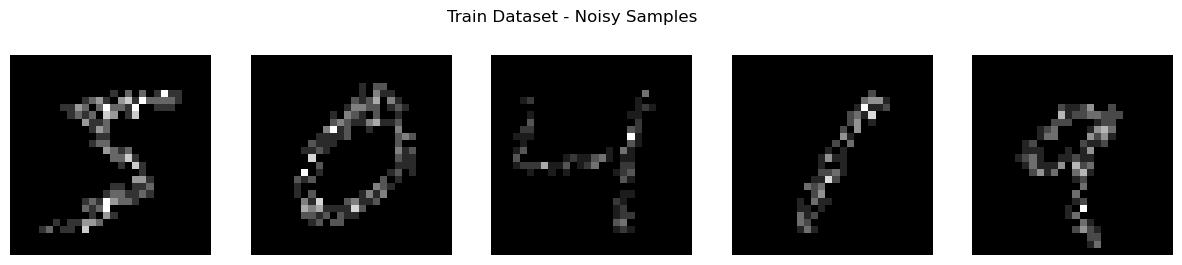

Visualizing noisy samples from test dataset:


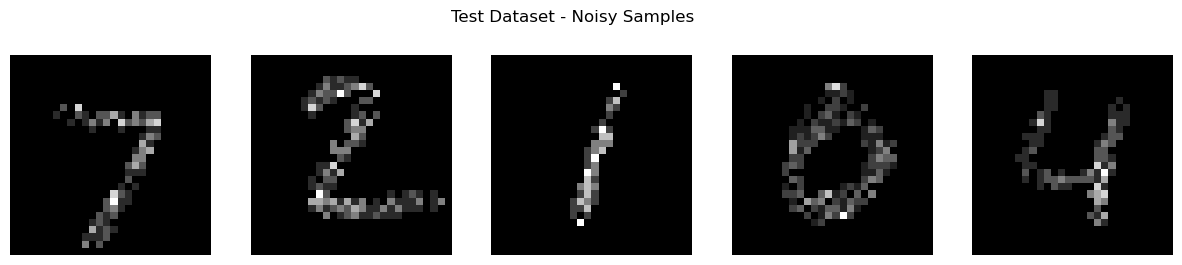

In [16]:
def map_to_minus_one_to_one(x):
    return x * 2 - 1  # [0, 1] -> [-1, 1]

class NoisySinogramDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, _ = self.original_dataset[idx]
        noisy_image = add_poisson_noise(image)  # Add Gaussian noise
        noisy_sinogram = apply_radon_transform(noisy_image)  # Radon transform
        clean_sinogram = apply_radon_transform(image)  # Radon transform without noise

        # Map images and sinograms to [-1, 1]
        noisy_image = map_to_minus_one_to_one(noisy_image)
        noisy_sinogram = map_to_minus_one_to_one(noisy_sinogram)
        clean_sinogram = map_to_minus_one_to_one(clean_sinogram)

        return noisy_image, noisy_sinogram, clean_sinogram

train_dataset = NoisySinogramDataset(train_dataset)
test_dataset = NoisySinogramDataset(test_dataset)
# Visualization checkpoint: Noisy dataset samples
def visualize_samples(dataset, num_samples=5, title="Samples"):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image, _, _ = dataset[i]
        axes[i].imshow(image.squeeze(0), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize noisy samples from train and test datasets
print("Visualizing noisy samples from train dataset:")
visualize_samples(train_dataset, num_samples=5, title="Train Dataset - Noisy Samples")

print("Visualizing noisy samples from test dataset:")
visualize_samples(test_dataset, num_samples=5, title="Test Dataset - Noisy Samples")

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN for denoising
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_model = DenoisingCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(denoising_model.parameters(), lr=learning_rate)

# Train the denoising network
for epoch in range(num_epochs):
    denoising_model.train()
    for batch_idx, (_, noisy_sinograms, clean_sinograms) in enumerate(train_loader):  # 忽略 noisy_image
        noisy_sinograms, clean_sinograms = noisy_sinograms.to(device), clean_sinograms.to(device)

        # Forward pass
        denoised_sinograms = denoising_model(noisy_sinograms)
        loss = criterion(denoised_sinograms, clean_sinograms)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 3.7501
Epoch [2/5], Loss: 3.3566
Epoch [3/5], Loss: 3.5468
Epoch [4/5], Loss: 2.9124
Epoch [5/5], Loss: 2.9503


Visualizing sinograms and reconstructions during testing:


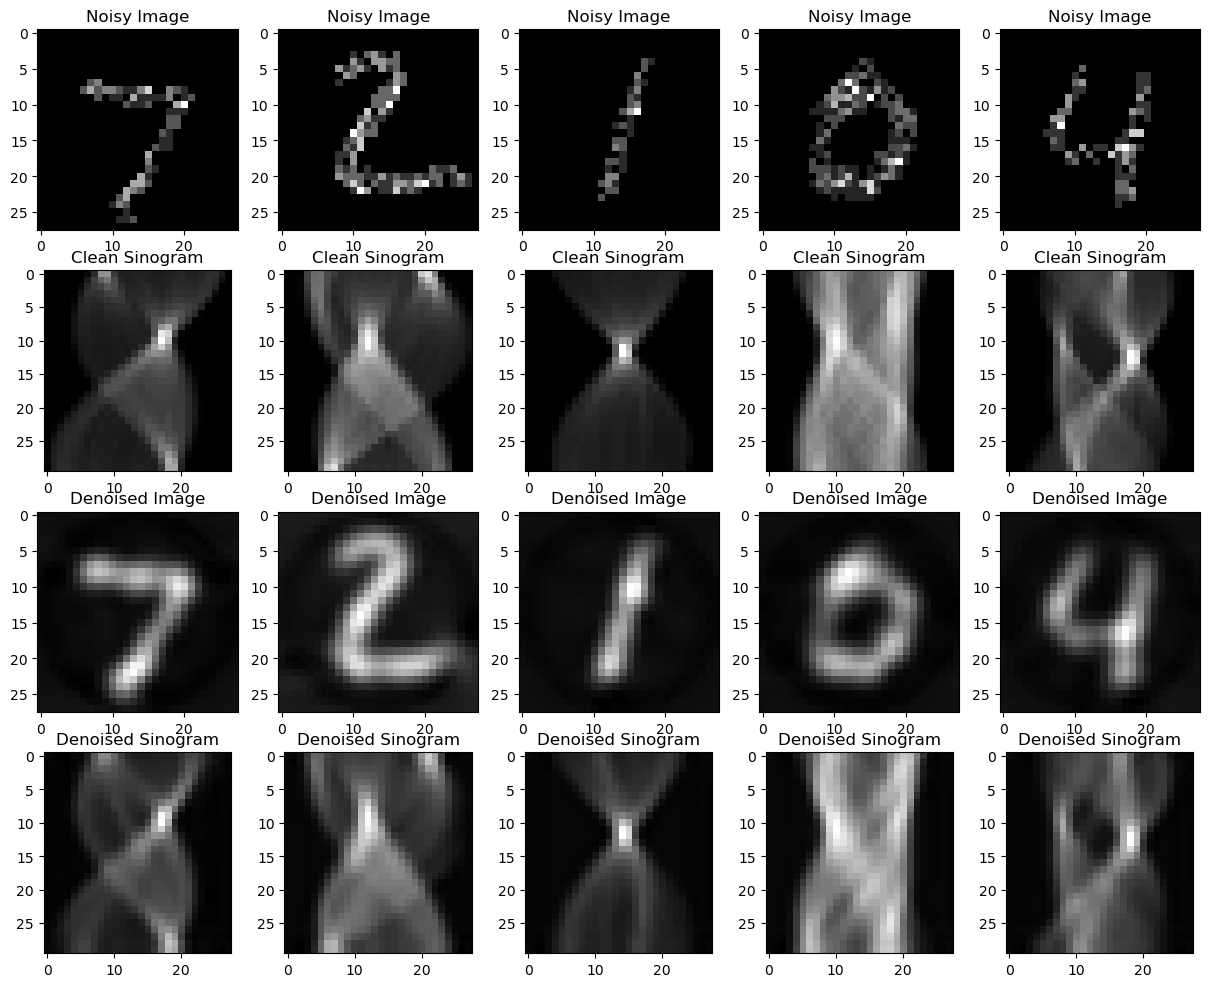

In [18]:
# Test the denoising network
denoising_model.eval()
with torch.no_grad():
    for batch_idx, (noisy_images, noisy_sinograms, clean_sinograms) in enumerate(test_loader):
        noisy_images = noisy_images.to(device)
        noisy_sinograms = noisy_sinograms.to(device)
        denoised_sinograms = denoising_model(noisy_sinograms)

        # Visualization checkpoint: During testing
        print("Visualizing sinograms and reconstructions during testing:")
        fig, axes = plt.subplots(4, 5, figsize=(15, 12))
        for i in range(5):
            axes[0, i].imshow(noisy_images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0, i].set_title("Noisy Image")
            axes[1, i].imshow(clean_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1, i].set_title("Clean Sinogram")
            axes[2, i].imshow(reconstruct_fbp(denoised_sinograms[i].cpu().numpy().squeeze()), cmap='gray')
            axes[2, i].set_title("Denoised Image")
            axes[3, i].imshow(denoised_sinograms[i].cpu().numpy().squeeze(), cmap='gray')
            axes[3, i].set_title("Denoised Sinogram")
        plt.show()

        break  # Visualize one batch only